In [1]:
# Import the necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from torch.utils.checkpoint import checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

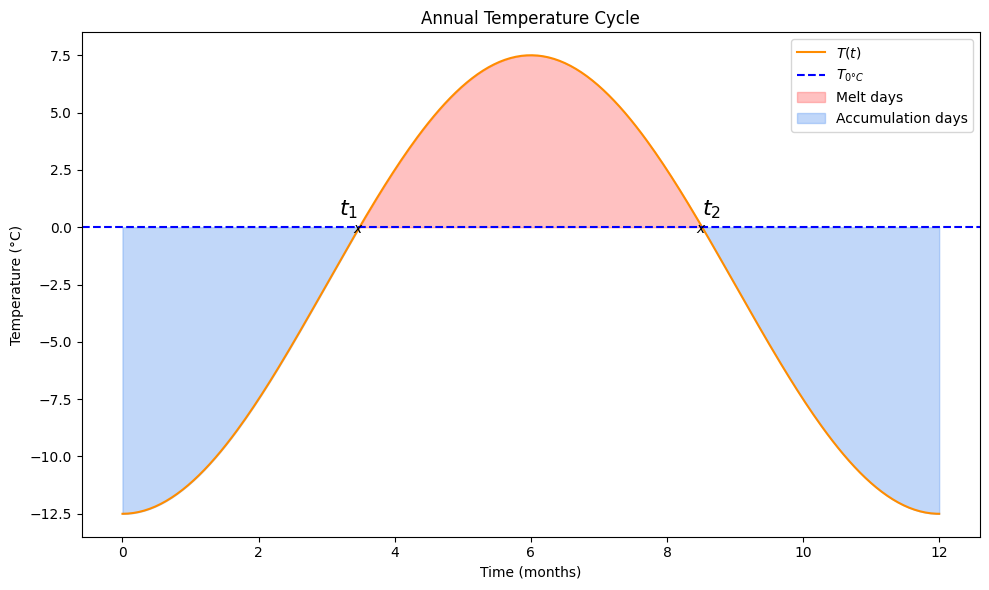

The integral is: 24.39718534134498


In [2]:
# Constants
T_m = -2.5     # Mean annual temperature in degrees Celsius
T_s = 10  # Seasonal amplitude
A = 12      # Period in months (one year)

# Time array: monthly resolution for a full year
t = np.linspace(0, A, 300)

# Temperature function
T_abl = T_m - T_s * np.cos(2 * np.pi * t / A)

# Compute t1 and t2
t1 = (A / (2 * np.pi)) * np.arccos(T_m / T_s)
t2 = A - t1

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, T_abl, label=r'$T(t)$', color='darkorange')
plt.axhline(y=0, color='blue', linestyle='--', label=r'$T_{0°C}$')

# Fill area under curve between t1 and t2
mask_red = (t >= t1) & (t <= t2)
plt.fill_between(t, T_abl, 0, where=mask_red, interpolate=True, color='#FF6464', alpha=0.4, label='Melt days')

# Fill area between curve and T=0 for t in [0, t1]
mask_blue1 = (t >= 0) & (t <= t1)
plt.fill_between(t, T_abl, 0, where=mask_blue1, interpolate=True, color='#659DF2', alpha=0.4, label='Accumulation days')
mask_blue2 = (t >= t2) & (t <= A)
plt.fill_between(t, T_abl, 0, where=mask_blue2, interpolate=True, color='#659DF2', alpha=0.4)

# Annotations
plt.text(t1 - 0.3, 0.5, r'$t_1$', color='black', fontsize=16)
plt.text(t2, 0.5, r'$t_2$', color='black', fontsize=16)
plt.text(t1 - 0.09, -0.25, r'$x$', color='black', fontsize=10)
plt.text(t2 - 0.09, -0.25, r'$x$', color='black', fontsize=10)

# Title and labels
plt.title('Annual Temperature Cycle')
plt.xlabel('Time (months)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.savefig('annual_temp.png')
plt.show()

# Integral calculation
ratio = T_m / T_s
integral = (
    T_m * (A - (A / np.pi) * np.arccos(ratio)) +
    (T_s * A / np.pi) * np.sqrt(1 - ratio**2)
)
print("The integral is:", integral)


In [3]:
def compute_integral_positive_temperature(T_m, T_s):
    """
    Computes the integral of T_abl(t) over the period where T_abl > 0 (PyTorch version).
    """
    A = 12.0  # months
    scale = 1.1 # to make the function more linear for [-0.5,0.5]
    return T_m * (A - (A / torch.pi) * torch.acos(torch.tanh(scale *T_m / T_s)))+(T_s * A / torch.pi) * torch.sqrt(1 - (torch.tanh(scale *T_m / T_s))**2)

def apply_lapse_rate(topography, T_m_lowest):
    lapse_rate = 6.0 / 1000.0  # 6°C/km
    min_altitude = torch.min(topography)
    delta_alt = topography - min_altitude

    T_m = T_m_lowest - lapse_rate * delta_alt
    
    return T_m

def compute_negative_temperature_ratio(T_m, T_s):
    """
    Computes the ratio of the year when the temperature is negative (PyTorch version).
    Parameters:
        T_m (Tensor): 2D tensor of mean annual temperatures (on device)
        T_mj (Tensor): 2D tensor of hottest month temperatures (on device)
    Returns:
        Tensor: 2D tensor of negative temperature ratios (values between 0 and 1)
    """
    scale = 1.1 # to make the function more linear for [-0.5,0.5]
    return (1.0 / torch.pi) * torch.acos(torch.tanh(scale *T_m / T_s))


In [4]:
# Define SMB parameters directly
melt_f = 2 / 12  # m water / (°C·year)
smb_oggm_wat_density = 1000.0  # kg/m³
smb_oggm_ice_density = 910.0   # kg/m³

def update_smb(Z_topo, precipitation, T_m_lowest, T_s):
    """
    Compute the surface mass balance (SMB)

    Inputs:
        Z_topo         : Topography [Unit: m]
        precipitation  : Annual precip. [Unit: m y⁻¹ (water)]
        T_m_lowest     : Mean annual temp at lowest point [Unit: °C]
        T_mj_lowest    : Max month temp at lowest point [Unit: °C]

    Output:
        smb            : Surface mass balance [Unit: m ice eq. / y]
    This mass balance routine implements the OGGM surface mass balance model.
    """

    # Apply lapse rate to get temperature fields
    T_m = apply_lapse_rate(Z_topo, T_m_lowest)

    # Compute accumulation in water equivalent [m y⁻¹]
    accumulation = precipitation * compute_negative_temperature_ratio(T_m, T_s)

    # Compute ablation (melt) in water equivalent [m y⁻¹]
    ablation = melt_f * compute_integral_positive_temperature(T_m, T_s)

    # Convert to ice equivalent and compute final SMB
    smb = (accumulation - ablation) * (smb_oggm_wat_density / smb_oggm_ice_density)

    return smb


In [5]:
precip = 2.7 # e.g., m/year
T_m_lowest = 6 # °C at lowest elevation
T_s= 10  # °C at lowest elevation

nc_file = netCDF4.Dataset('../data/geology_200m.nc')
# nc_file = netCDF4.Dataset('AIF-v1/output-500.nc')
Z_topo = torch.tensor(nc_file.variables['topg'][:], device=device)

# Constant precipitation

smb = update_smb(Z_topo,precip,T_m_lowest, T_s)

In [6]:
T_m = apply_lapse_rate(Z_topo, T_m_lowest)
ratio=compute_negative_temperature_ratio(T_m, T_s)
integral = compute_integral_positive_temperature(T_m, T_s)

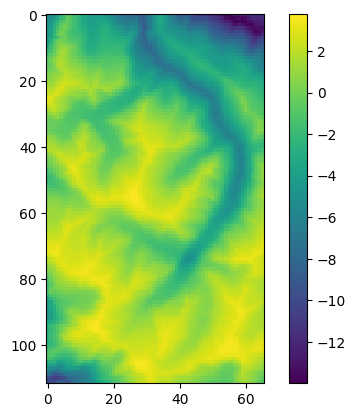

In [7]:
smb_npy = (smb).to(torch.float32).detach().cpu().numpy()

plt.imshow(smb_npy)
plt.colorbar()
plt.show()

In [8]:
# Prepare hooks for tensors 
def print_hook_b(grad):
    print("\n Gradient is :", torch.norm(grad))
    return grad

def reduce_hook(g):
    scale= 0.1
    g2 = torch.atan(scale*g)/scale
    # print(f"[reduce_hook]  incoming {torch.norm(g)} → outgoing {torch.norm(g2)}")
    return g2
def reduce_hook2(g):
    scale= 0.1
    g2 = torch.atan(scale*g)/scale
    # print(f"[H_Ice]  incoming {torch.norm(g)} → outgoing {torch.norm(g2)}")
    return g2
def increase_hook(grad):
    return grad * 2

In [9]:
value= torch.tensor(100.0)
scale= 0.1
print(torch.atan(scale * value) / scale)

tensor(14.7113)


### Prepare the spatial-temporal observations

In [10]:
nc_file = netCDF4.Dataset('../data/geology_200m.nc')
Z_topo = torch.tensor(nc_file.variables['topg'][:], device=device)
thk_1880 = torch.tensor(nc_file.variables['thk_1880'][:], device=device)
ice_mask = torch.tensor(nc_file.variables['icemask'][:], device=device)

ttot = 90  # Time limit (yr)
t_start=1880.

rho, g, fd = torch.tensor([910.0, 9.81,0.25e-16], device=device) # units [kg/m^3, m/s^-2, Pa^-3year^-1]
dx=200
dy=200
Lx=Z_topo.shape[1]*dx
Ly=Z_topo.shape[0]*dy
nc_file.close()
torch.save(thk_1880,'Obs_2D.pt')


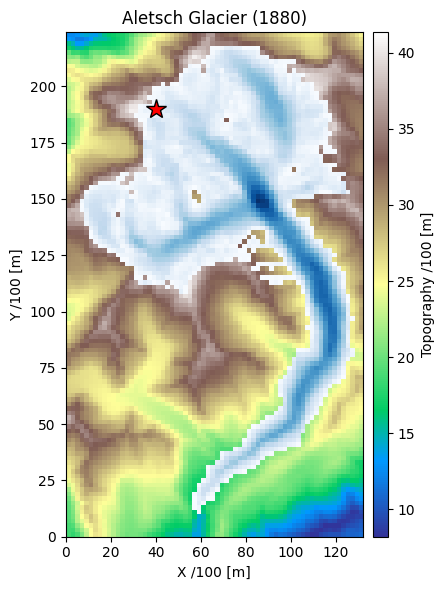

In [11]:
# Convert to NumPy
Z_topo_npy = Z_topo.to(torch.float32).cpu().numpy()
thk_1880_npy = thk_1880.to(torch.float32).cpu().numpy()

# Define the extent: [xmin, xmax, ymin, ymax]
extent = [0, Lx/100, 0, Ly/100]
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot topography
img = ax.imshow((Z_topo_npy + thk_1880_npy)/100, cmap='terrain', origin='lower',extent=extent)

# Create divider for colorbar and reduce padding
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # pad controls the spacing
cbar = fig.colorbar(img, cax=cax)
cbar.set_label('Topography /100 [m]')

# Overlay glacier thickness
thk_display = np.ma.masked_where(thk_1880_npy <= 0, thk_1880_npy)
ax.imshow(thk_display, cmap='Blues', alpha=1, origin='lower',extent=extent)

# Titles and labels
ax.set_title("Aletsch Glacier (1880)")
ax.set_xlabel("X /100 [m]")
ax.set_ylabel("Y /100 [m]")
# Add the red star marker
ax.plot(40,190, marker='*', color='red', markersize=15, markeredgecolor='black')


plt.tight_layout()
plt.show()

In [12]:
class GlacierDynamicsCheckpointed(torch.nn.Module):
    def __init__(self, Z_topo, ttot, rho, g, fd, Lx, Ly, dx, dy, dtmax, device, ice_mask):
        super().__init__()
        self.Z_topo = Z_topo
        self.ice_mask=ice_mask
        self.ttot = ttot
        self.rho = rho
        self.g = g
        self.fd = fd
        self.Lx = Lx
        self.Ly = Ly
        self.dx = dx
        self.dy = dy
        self.dtmax = dtmax
        self.device = device
        

    def forward(self, precip_tensor, T_m_lowest, T_s):
        return self.solve_glacier_dynamics(self.Z_topo, self.ttot,precip_tensor, T_m_lowest, T_s)

    def solve_glacier_dynamics(self, Z_topo, ttot,precip_tensor,T_m_lowest, T_s):
        nx = int(self.Lx / self.dx)
        ny = int(self.Ly / self.dy)

        epsilon = torch.tensor(1.e-10, device=self.device)
        H_ice = torch.zeros((ny, nx), device=self.device,requires_grad=True)

        # H_ice = H_initial.to(device=device)
        
        Z_surf = Z_topo + H_ice

        time = torch.tensor(0., device=self.device)
        # dt = torch.tensor(self.dtmax, device=self.device)
        it = torch.tensor(0., device=self.device)
        t_freq=torch.tensor(2., device=self.device)
        t_last_update=torch.tensor(0., device=self.device)
        #initial smb 
        smb = update_smb(Z_surf,precip_tensor,T_m_lowest, T_s)

        def checkpointed_step(H_ice, Z_surf,smb, time):
            # Compute H_avg
            H_avg = 0.25 * (H_ice[:-1, :-1] + H_ice[1:, 1:] + H_ice[:-1, 1:] + H_ice[1:, :-1])

            # Compute Snorm
            Sx = (Z_surf[:, 1:] - Z_surf[:, :-1]) / self.dx
            Sy = (Z_surf[1:, :] - Z_surf[:-1, :]) / self.dy
            Sx = 0.5 * (Sx[:-1, :] + Sx[1:, :])
            Sy = 0.5 * (Sy[:, :-1] + Sy[:, 1:])
            Snorm = torch.sqrt(Sx**2 + Sy**2 + epsilon)
               
            # Compute diffusivity
            D = self.fd * (self.rho * self.g)**3.0 * H_avg**5 * Snorm**2 + epsilon

            # Compute adaptive time step.
            dt_value = min(min(self.dx, self.dy)**2 / (2.7 * torch.max(D).item()), self.dtmax)
            dt = torch.tensor(dt_value, dtype=torch.float32, device=self.device, requires_grad=True)

            # Compute fluxes
            qx = -(0.5 * (D[:-1, :] + D[1:, :])) * (Z_surf[1:-1, 1:] - Z_surf[1:-1, :-1]) / self.dx
            qy = -(0.5 * (D[:, :-1] + D[:, 1:])) * (Z_surf[1:, 1:-1] - Z_surf[:-1, 1:-1]) / self.dy

            # Compute thickness change rate
            dHdt = -(torch.diff(qx, dim=1) / self.dx + torch.diff(qy, dim=0) / self.dy)

            # Update ice thickness
            H_ice = H_ice.clone()
            H_ice[1:-1, 1:-1] = H_ice[1:-1, 1:-1] + dt * dHdt

            H_ice = H_ice.clone()
            smb.register_hook(reduce_hook)

            H_ice[1:-1, 1:-1] = H_ice[1:-1, 1:-1] + dt * smb[1:-1, 1:-1]

            # Ensure ice thickness remains positive
            H_ice = torch.relu(H_ice)

            # Update surface topography
            Z_surf = Z_topo + H_ice
            if Z_surf.requires_grad:
                Z_surf.retain_grad()                # Required to keep .grad field
                Z_surf.register_hook(reduce_hook2)   # Now hook will be called during backward
            return H_ice, Z_surf, time + dt

        while time < ttot:           
            
            # unroll = 1000          # window length

            H_ice, Z_surf, time = checkpoint(checkpointed_step, H_ice, Z_surf, smb, time)
            it += 1
            # Compute surface mass balance (SMB)
            if (time-t_last_update)>=t_freq:
                smb = update_smb(Z_surf,precip_tensor,T_m_lowest, T_s) 
                # smb.retain_grad() 

                
                t_last_update=time.clone()
                
            # if it % unroll == 0:
            # #     # cut the graph
            #     H_ice = H_ice.detach().requires_grad_()
            #     Z_surf = Z_surf.detach().requires_grad_()
            #     # precip_tensor.detach().requires_grad_()
            #     # T_ma_lowest.detach().requires_grad_()
            #     # T_mj_lowest.detach().requires_grad_()
        return H_ice

# Wrap the solve_glacier_dynamics function in the checkpointed module
glacier_model = GlacierDynamicsCheckpointed(Z_topo, ttot, rho, g, fd, Lx, Ly, dx, dy, 1, device,ice_mask)

# Replace the direct call with a call to the checkpointed model
H_simulated = glacier_model(precip,T_m_lowest, T_s)
torch.save(H_simulated,'Obs_2D.pt')

/home/klleshi/miniconda3/envs/IGEM/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


In [13]:
def visualize(Z_surf,time,H_ice):
        plt.figure(2, figsize=(11, 4), dpi=200)
        # First subplot: Ice surface
        plt.subplot(1, 2, 1)
        plt.imshow(Z_surf.cpu().numpy(), cmap='terrain', origin='lower')
        plt.colorbar(label='Elevation (m)')
        plt.title('Ice Surface at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')
        # Second subplot: Ice thickness
        plt.subplot(1, 2, 2)
        plt.imshow(np.where(H_ice.cpu().numpy() > 0, H_ice.cpu().numpy(), np.nan), cmap='jet', origin='lower')
        plt.colorbar(label='Ice Thickness (m)')
        plt.title('Ice Thickness at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')
        # Show the plot
        plt.show()

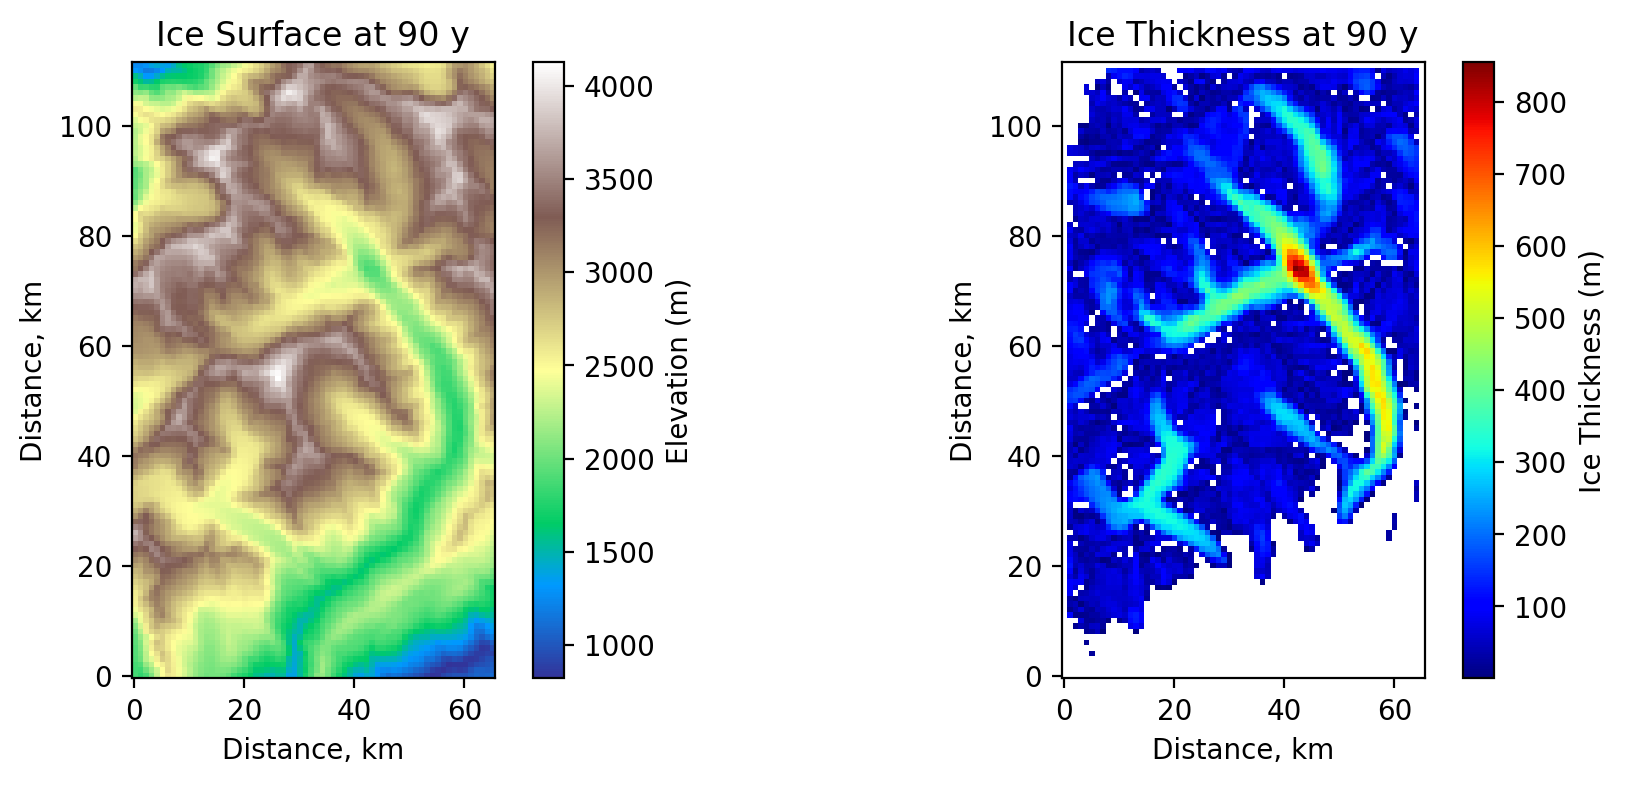

In [14]:
visualize(Z_topo,ttot,H_simulated.detach())

#### Inversion options 
**Mean Square Error (MSE)**:

* Recomended for the case where we have glacier thickness. Converges the fastest.  


**Intersection over Union (IoU)**: 

* Also known as the **Jaccard Index**, this measures the overlap between simulated and observed extents. We use this option when we do not have information about the glacier thickness.


In [15]:
# # Define a function for the forward computation to use with checkpointing
def inversion_thicknes(precip_tensor, T_m_lowest, T_s,observed_thk, reg_lambda):
    # Perform forward simulation
    H_simulated = glacier_model(precip_tensor,T_m_lowest, T_s)
    # Compute data fidelity term
    data_fidelity = torch.mean(torch.abs(H_simulated - observed_thk) ** 2)/torch.norm(observed_thk)

    # Compute smoothness regularization
    smoothness_x = torch.sum((precip_tensor[:, 1:] - precip_tensor[:, :-1]) ** 2)
    smoothness_y = torch.sum((precip_tensor[1:, :] - precip_tensor[:-1, :]) ** 2)
    smoothness_reg = smoothness_x + smoothness_y

    # Total loss
    loss = data_fidelity + reg_lambda * smoothness_reg
    return loss,H_simulated

# Define a function for the forward computation to use with checkpointing
def inversion_extent(precip_tensor,temp_low,temp_high, observed_thk):
    """
    Forward computation with IoU for data fidelity and smoothness regularization.

    Args:
        Z_ELA (torch.Tensor): The equilibrium line altitude field.
        observed_thk (torch.Tensor): The observed glacier thickness.
        reg_lambda (float): Regularization parameter for smoothness.
        threshold (float): Thickness threshold to define glacier extent.

    Returns:
        loss (torch.Tensor): Total loss including IoU and regularization.
        H_simulated (torch.Tensor): Simulated glacier thickness.
    """
    # Perform forward simulation
    H_simulated =  glacier_model(precip_tensor, T_ma_lowest,T_mj_lowest)  # Use the checkpointed glacier model
    
    # Steeper sigmoid using a scaling factor
    scale = 100.0
    mask_simulated = torch.sigmoid(scale * (H_simulated - 1))
    mask_observed = torch.sigmoid(scale * (observed_thk - 1))

    # Compute data fidelity term
    data_fidelity = torch.mean(torch.abs(mask_simulated - mask_observed) ** 2)
    # Compute smoothness regularization
    smoothness_x = torch.sum((precip_tensor[:, 1:] - precip_tensor[:, :-1]) ** 2)
    smoothness_y = torch.sum((precip_tensor[1:, :] - precip_tensor[:-1, :]) ** 2)
    smoothness_reg = smoothness_x + smoothness_y
    
    reg_lambda=0.000
    # Total loss
    loss = data_fidelity + reg_lambda * smoothness_reg

    return loss, H_simulated


In [25]:
# Reset the starting point in tracking maximum GPU memory occupied by tensors in bytes for a given device.
torch.cuda.reset_peak_memory_stats()

# Initial guesses for inversion problem
precip_tensor = torch.full(Z_topo.shape,2.0, requires_grad=True, device=device)
# T_m_lowest = torch.tensor(4.0, requires_grad=True, device=device)
# T_s = torch.tensor(10.0, requires_grad=True, device=device)

# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk = torch.load('Obs_2D.pt').to(device)

# Hyperparameters
initial_lr = 0.1
reg_lambda = 0.001
n_iterations = 15

# Optimizer setup
optimizer = torch.optim.Adam([precip_tensor], lr=initial_lr)
# optimizer = torch.optim.Adam([precip_tensor, T_m_lowest, T_s], lr=initial_lr)

# Tracking variables
total_loss_history = []
data_fidelity_history = []
regularization_history = []
total_gradients_history = []

# Main loop
for i in range(n_iterations):
    start_time = time.time()
    optimizer.zero_grad()
    print(f'Nb iterations: {i + 1} {50*'-'}')


    # Forward pass with gradient checkpointing
    loss, H_simulated = inversion_thicknes(precip_tensor, T_m_lowest, T_s, observed_thk, reg_lambda)

    # Backward pass
    loss.backward()
    # Collect gradient norms
    grad_norms = []
    for param in optimizer.param_groups[0]['params']:
        norm = torch.norm(param.grad)
        print(f'Gradient norm of parameter: {norm:.4f}')

    # Optimizer step
    optimizer.step()

    # Log timing
    elapsed_time = time.time() - start_time
    print(f"Iteration {i + 1} took {elapsed_time:.2f} seconds. precip mean = {precip_tensor.mean().item():.3f}")
    # Store history
    total_loss_history.append(loss.item())
    total_gradients_history.append(torch.norm(precip_tensor.grad).item())

    # with torch.no_grad():
    #     # visualize(precip_tensor[0],i,H_simulated,Lx,Ly)
    #     data_fidelity = torch.mean((H_simulated - observed_thk) ** 2).item()
    #     data_fidelity_history.append(data_fidelity)
    #     print(data_fidelity)



/tmp/ipykernel_34371/3070247234.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  observed_thk = torch.load('Obs_2D.pt').to(device)


Nb iterations: 1 --------------------------------------------------
Gradient norm of parameter: 132.5513
Iteration 1 took 109.64 seconds. precip mean = 1.989
3293.089111328125
Nb iterations: 2 --------------------------------------------------
Gradient norm of parameter: 3.9605
Iteration 2 took 114.83 seconds. precip mean = 1.987
3278.075927734375
Nb iterations: 3 --------------------------------------------------
Gradient norm of parameter: 26.7490
Iteration 3 took 121.08 seconds. precip mean = 1.971
3347.98583984375
Nb iterations: 4 --------------------------------------------------
Gradient norm of parameter: 34.1553
Iteration 4 took 117.86 seconds. precip mean = 1.967
3153.262451171875
Nb iterations: 5 --------------------------------------------------
Gradient norm of parameter: 56.4306
Iteration 5 took 122.34 seconds. precip mean = 1.972
3230.8642578125
Nb iterations: 6 --------------------------------------------------
Gradient norm of parameter: 6.2508
Iteration 6 took 127.31 s

In [17]:
# torch.save(precip_tensor,"percip.pt")

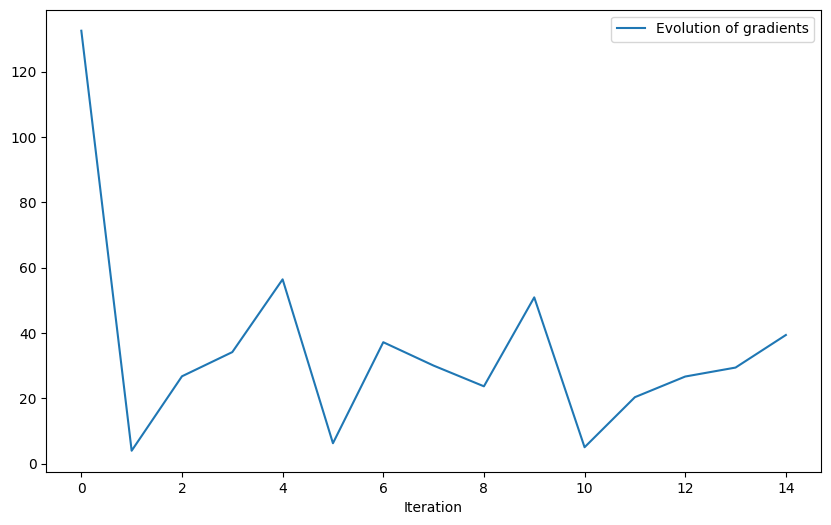

In [26]:
def plot_gradient_evolution(total_gradients_history,name):
    plt.figure(figsize=(10,6))
# plt.plot(ELA_evolution,label="evolution of ELA",color='b')
    plt.plot(total_gradients_history, label='Evolution of gradients')
    plt.xlabel('Iteration')
    plt.legend()
    plt.savefig(name)
plot_gradient_evolution(total_gradients_history,'kot.png')

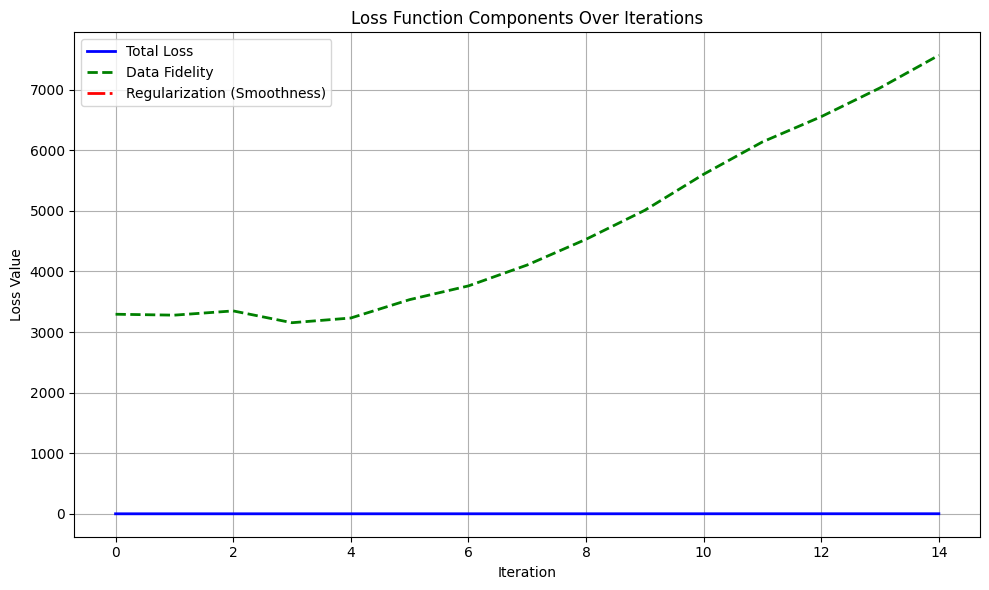

In [27]:
# Plot loss components
def plot_loss_components(total_loss_history, data_fidelity_history, regularization_history,name):
    plt.figure(figsize=(10, 6))
    plt.plot(total_loss_history, label='Total Loss', color='b', linewidth=2)
    plt.plot(data_fidelity_history, label='Data Fidelity', color='g', linestyle='--', linewidth=2)
    plt.plot(regularization_history, label='Regularization (Smoothness)', color='r', linestyle='-.', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.title('Loss Function Components Over Iterations')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(name)
plot_loss_components(total_loss_history, data_fidelity_history, regularization_history,'kot.png')

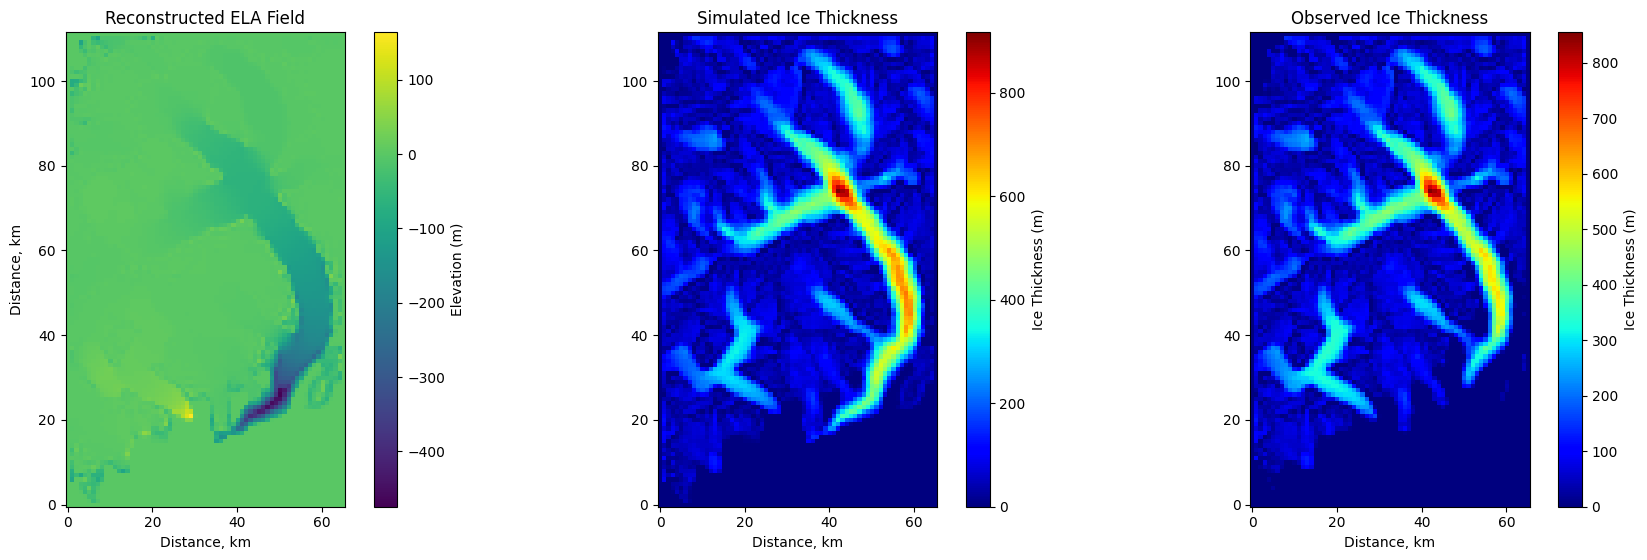

In [20]:
# Convert tensors to NumPy arrays for plotting
Z_ELA_np = precip_tensor.to(torch.float32).detach().cpu().numpy()
H_ice_np = H_simulated.to(torch.float32).detach().cpu().numpy()
observed_thk_np = observed_thk.to(torch.float32).detach().cpu().numpy()

# Create a figure with three subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize for better layout

# Plot the ELA field
im1 = ax[0].imshow(observed_thk_np-H_ice_np, origin='lower')
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='Elevation (m)')
ax[0].set_title('Reconstructed ELA Field')
ax[0].set_xlabel('Distance, km')
ax[0].set_ylabel('Distance, km')

# Second subplot: Ice thickness (simulated)
im2 = ax[1].imshow( H_ice_np, cmap='jet', origin='lower')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='Ice Thickness (m)')
ax[1].set_title('Simulated Ice Thickness')
ax[1].set_xlabel('Distance, km')

# Third subplot: Observed ice thickness
im3 = ax[2].imshow(observed_thk_np, cmap='jet', origin='lower')
fig.colorbar(im3, ax=ax[2], orientation='vertical', label='Ice Thickness (m)')
ax[2].set_title('Observed Ice Thickness')
ax[2].set_xlabel('Distance, km')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()


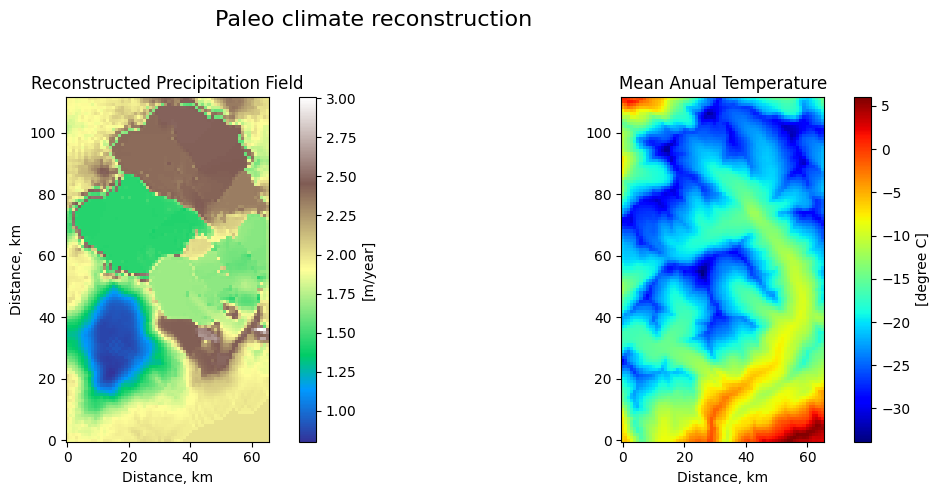

In [21]:
# Convert tensors to NumPy arrays for plotting
Precipitation = precip_tensor.to(torch.float32).detach().cpu().numpy()
mean_anual_T= apply_lapse_rate(Z_topo+H_simulated, T_m)

# Create a figure with three subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize for better layout

# Plot the ELA field
im1 = ax[0].imshow(Precipitation, cmap='terrain', origin='lower')
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='[m/year]')
ax[0].set_title('Reconstructed Precipitation Field')
ax[0].set_xlabel('Distance, km')
ax[0].set_ylabel('Distance, km')

# Second subplot: Ice thickness (simulated)
im2 = ax[1].imshow(mean_anual_T.detach().cpu().numpy(), cmap='jet', origin='lower')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='[degree C]')
ax[1].set_title('Mean Anual Temperature')
ax[1].set_xlabel('Distance, km')

# Add a main title
fig.suptitle('Paleo climate reconstruction', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()

In [22]:
# Convert tensors to NumPy arrays for plotting
Precipitation = precip_tensor.to(torch.float32).detach().cpu().numpy()
Z_ELA_np = Precipitation[0]
H_ice_np = H_simulated.to(torch.float32).detach().cpu().numpy()
observed_thk_np = observed_thk.to(torch.float32).detach().cpu().numpy()
mean_anual_T, mean_June_T = apply_lapse_rate(Z_topo + H_simulated, T_ma_lowest, T_mj_lowest)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 10))

# --- Top Row ---
# Reconstructed Precipitation
im0 = axs[0, 0].imshow(Z_ELA_np, cmap='terrain', origin='lower')
fig.colorbar(im0, ax=axs[0, 0], orientation='vertical', label='[m/year]')
axs[0, 0].set_title('Reconstructed Precipitation Field')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Distance, km')

# Simulated Ice Thickness
im1 = axs[0, 1].imshow(H_ice_np, cmap='jet', origin='lower')
fig.colorbar(im1, ax=axs[0, 1], orientation='vertical', label='Ice Thickness [m]')
axs[0, 1].set_title('Simulated Ice Thickness')
axs[0, 1].set_xlabel('')
# Remove y-axis for top-right panel
axs[0, 1].set_ylabel('')
axs[0, 1].set_yticklabels([])

# --- Bottom Row ---
# Mean Annual Temperature
im2 = axs[1, 0].imshow(mean_anual_T.detach().cpu().numpy(), cmap='jet', origin='lower')
fig.colorbar(im2, ax=axs[1, 0], orientation='vertical', label='[°C]')
axs[1, 0].set_title('Mean Annual Temperature')
axs[1, 0].set_xlabel('Distance, km')
axs[1, 0].set_ylabel('Distance, km')

# Thickness Difference (Observed - Simulated)
im3 = axs[1, 1].imshow(observed_thk_np - H_ice_np, cmap='coolwarm', origin='lower')
fig.colorbar(im3, ax=axs[1, 1], orientation='vertical', label='Difference [m]')
axs[1, 1].set_title('Thickness Difference (Obs - Simul)')
axs[1, 1].set_xlabel('Distance, km')
# Remove y-axis for bottom-right panel
axs[1, 1].set_ylabel('')
axs[1, 1].set_yticklabels([])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

NameError: name 'T_ma_lowest' is not defined